## **Previsão de acidentes em Recife**

### Objetivo:
Baseado nos registros de ocorrência de acidentes em Recife (2015-2019), criar um modelo de previsão de séries temporais. Para isso, os dados de 2015 à 2018 serão utilizados como treinamento do modelo. Já os dados de 2019 serão utilizados para validação do modelo aplicando-se a validação walk-foward.  

### Etapas nesse notebook:
5. Criação de modelos
6. Análise das métricas
7. Variáveis exógenas

### 5. Criação de modelos

Baseado na série temporal estudada, é momento de iniciar a construção de modelos para a predição de valores futuros.

Modelos implementados:
1. ARIMA
2. SARIMA
3. Holt Winters

Contudo, antes de partir para a implementação é necessário relembrar algumas definições feitas na análise dos dados.

#### 5.1 Relembrando as análises da série temporal

In [1]:
import pandas as pd
df_freq = pd.read_csv('grouped_accident_data.csv')
df_freq.rename(columns={ df_freq.columns[0]: "Date" }, inplace = True)
df_freq['Date'] = pd.to_datetime(df_freq['Date'])
df = df_freq.set_index('Date')
df.head()

,Freq
Date,
2015-06-01,27
2015-06-02,29
2015-06-03,28
2015-06-04,20
2015-06-05,22


<ipython-input-2-8ac32ea97a24>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  full_ts_decomp = seasonal_decompose(df['Freq'], freq=365)


<AxesSubplot:xlabel='Date'>

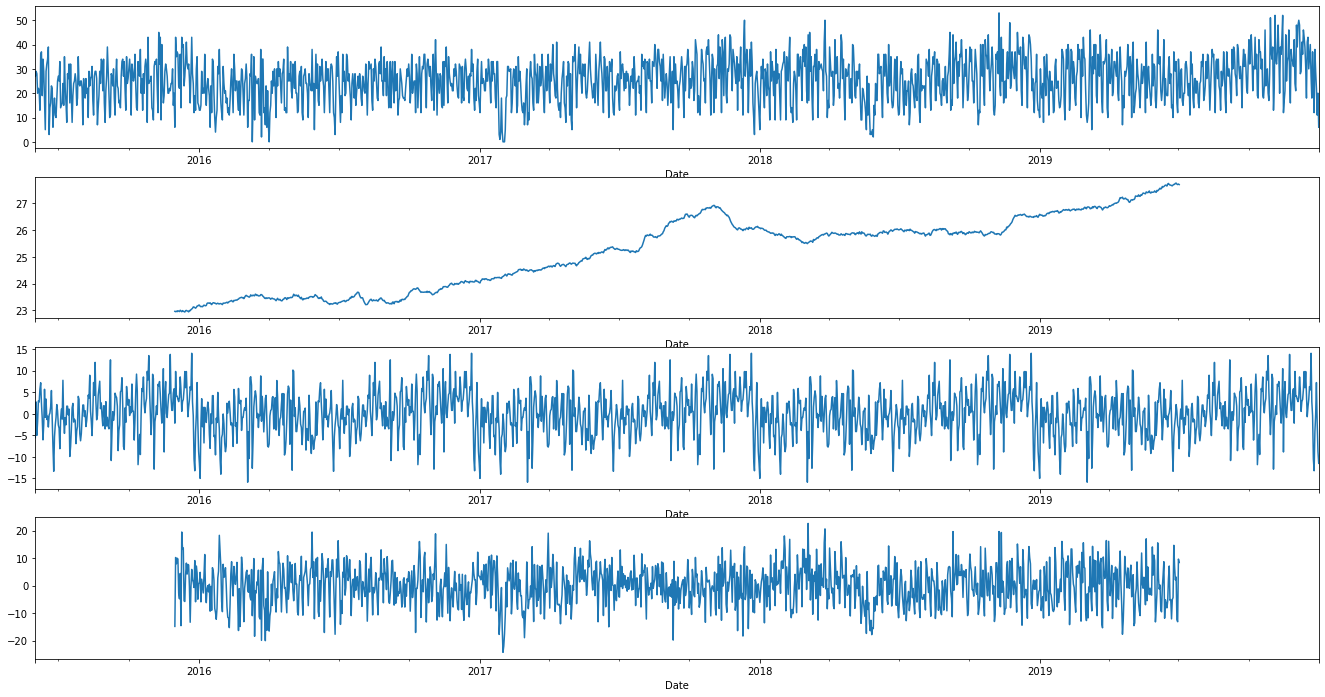

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

full_ts_decomp = seasonal_decompose(df['Freq'], freq=365)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(23,12))
full_ts_decomp.observed.plot(ax=ax1)
full_ts_decomp.trend.plot(ax=ax2)
full_ts_decomp.seasonal.plot(ax=ax3)
full_ts_decomp.resid.plot(ax=ax4)

A tendência da série decomposta é algo interessante de analisar. A princípio é possível perceber uma tendência, mas analisando o comportamento de 2015, 2016 e 2018, é possível perceber uma estabilidade. Já em 2017 e 2019 percebemos uma tendência de alta.

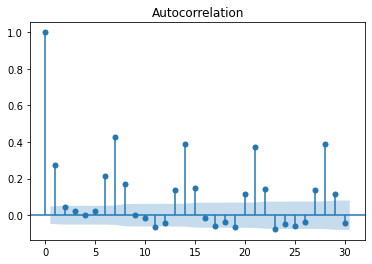

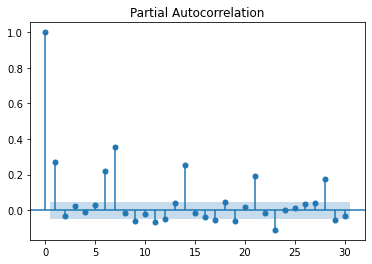

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_freq['Freq'], lags=30)
plot_pacf(df_freq['Freq'], lags=30)
plt.show()

Os gráficos de correlação possuem dois lags interessante de analisarmos. O primeiro é o lag 7 (provavelmente por conta da sazonalidade) e o primeiro lag também possui forte correlação.

#### 5.2 Modelo ARIMA

**AR:** um modelo é tido como auto regressivo quando o valor presente a ser predito está em função de uma média ponderada dos seus respectivos valores passados. Ele é representado pela seguinte equação:

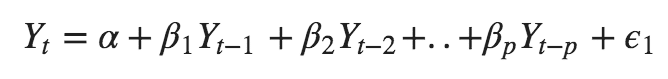

**MA:** um modelo é tido como média móvel quando o valor presente a ser predito é definido como uma combinação linear dos erros anteriores. Ele é representado pela seguinte equação:

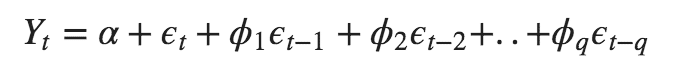


**I:** A variável I do modelo ARIMA corresponde a quantidade de derivações necessárias para que o modelo se torne estacionário.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

train_start_dt = '2015-06-01'
test_start_dt = '2019-01-01'
train = df.copy()[ (df.index >= train_start_dt) & (df.index < test_start_dt)][['Freq']]
test = df.copy()[df.index >= test_start_dt][['Freq']]

history = [x for x in train['Freq']]

# Stationary series
model_ar = ARIMA(history, order=(7,0,0))
model_ar_fitted = model_ar.fit() #Selected
model_ma = ARIMA(history, order=(0,0,7))
model_ma_fitted = model_ma.fit() #Selected
model_arma = ARIMA(history, order=(7,0,7))
model_arma_fitted = model_arma.fit() #Selected

# Non-stationary series
model_arima = ARIMA(history, order=(7,1,7))
model_arima_fitted = model_arima.fit()

In [ ]:
bics_arima = [model_ar_fitted.bic, model_ma_fitted.bic, model_arma_fitted.bic, 
        model_arima_fitted.bic]
bics_arima

In [ ]:
#Walk foward for ARIMA
def walk_forward_validation(p,d,q, train_data, test_data):
  history = [x for x in train_data] 
  predictions = list()
  for t in range(len(test_data)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

  return predictions

predictions_ar = walk_forward_validation(7,0,0, train['Freq'], list(test['Freq']))
predictions_ma = walk_forward_validation(0,0,7, train['Freq'], list(test['Freq']))
predictions_arma = walk_forward_validation(7,0,7, train['Freq'], list(test['Freq']))
#predictions_arima = walk_forward_validation(7,1,7, train['Freq'], list(test['Freq']))


Analisando a métrica BIC (critério de informação Bayseano) dos modelos ARIMA, é possível perceber que que houve uma significativa melhora do modelo ARMA para o MA e AR, mas que a diferenciação (ARIMA) não teve grande impacto nas métricas de treino.

*OBS: o modelo arima está comentado na predição pois iria demorar cerca de 6 horas para rodar localmente. Como existem outros modelos com maior potencial de acurácia, optei por não rodá-lo.*

#### 5.3 Modelo SARIMA

A diferença do modelo ARIMA para o SARIMA é a inclusão da sazonalidade como parâmetro na predição de novos valores. Para isso, incluímos novos parâmetros na equação final. O modelo pode ser representado pela seguinte formulação:

SARIMA = (p,q,d)x(P,Q,D)s

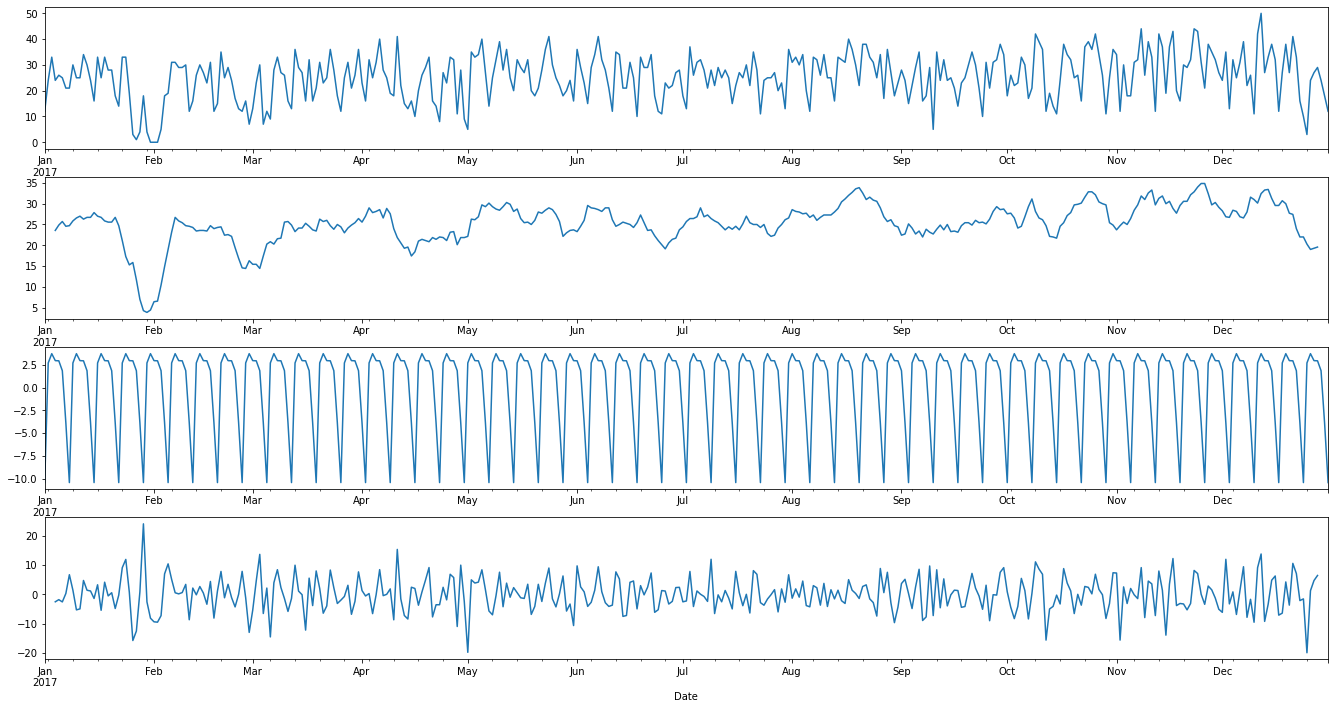

In [ ]:
sample_df = df['2017-01-01':'2017-12-31']
sample_ts_decomp = seasonal_decompose(sample_df['Freq'], freq=7)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(23,12))
sample_ts_decomp.observed.plot(ax=ax1)
sample_ts_decomp.trend.plot(ax=ax2)
sample_ts_decomp.seasonal.plot(ax=ax3)
sample_ts_decomp.resid.plot(ax=ax4)
plt.show()

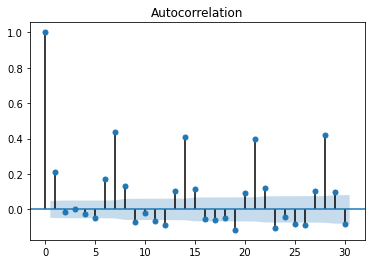

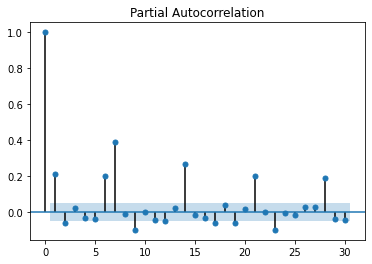

In [ ]:
no_seasonality_ts = full_ts_decomp.observed - full_ts_decomp.seasonal
plot_acf(no_seasonality_ts, lags=30)
plot_pacf(no_seasonality_ts, lags=30)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarma = SARIMAX(history, order=(1, 0, 1),seasonal_order=(1,0,1,7))
model_sarma_fitted = model_sarma.fit() #Selected
model_sarima = SARIMAX(history, order=(1, 0, 1),seasonal_order=(1,1,1,7))
model_sarima_fitted = model_sarima.fit() #Selected
model_sarima_2 = SARIMAX(history, order=(1, 0, 1),seasonal_order=(1,1,1,7))
model_sarima_2_fitted = model_sarima.fit() #Selected

In [ ]:
bics_sarima = [model_sarma_fitted.bic, model_sarima_fitted.bic]
bics_sarima

In [ ]:
#Walk foward for SARIMA
def walk_forward_validation_sarimax(p,d,q, P,D,Q,s, train_data, test_data, 
                                    exog = None, exog_test = None, n_feat = None):
  history = [x for x in train_data] 
  predictions = list()
  for t in range(len(test_data)):
    if exog is None:
      model = SARIMAX(history, order=(p, d, q),seasonal_order=(P,D,Q,s))
      model_fit = model.fit()
      output = model_fit.forecast()
    else:
      model = SARIMAX(history, exog = exog, order=(p, d, q),seasonal_order=(P,D,Q,s))
      model_fit = model.fit()
      output = model_fit.forecast(exog=np.reshape(exog_test[t],(1,n_feat)))
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    if exog is not None:
      exog = np.vstack([exog, exog_test[t]])
    print(t)
    #print('predicted=%f, expected=%f' % (yhat, obs))

  return predictions

#Walk foward for SARIMA forcing difference
def walk_forward_validation_sarimax_2(p,d,q, P,D,Q,s, train_data, test_data, 
                                    exog = None, exog_test = None, n_feat = None):
  history = [x for x in train_data] 
  predictions = list()
  for t in range(len(test_data)):
    if exog is None:
      model = SARIMAX(history, order=(p, d, q),seasonal_order=(P,D,Q,s))
      model_fit = model.fit()
      output = model_fit.forecast()
    else:
      model = SARIMAX(history, exog = exog, order=(p, d, q),seasonal_order=(P,D,Q,s))
      model_fit = model.fit()
      output = model_fit.forecast(exog=np.reshape(exog_test[t],(1,n_feat)))
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)
    if exog is not None:
      exog = np.vstack([exog, exog_test[t]])
    print(t)
    #print('predicted=%f, expected=%f' % (yhat, obs))

  return predictions

predictions_sarma = walk_forward_validation_sarimax(1,0,1,1,0,1,7, train['Freq'], list(test['Freq']))
predictions_sarima = walk_forward_validation_sarimax(1,0,1,1,1,1,7, train['Freq'], list(test['Freq']))
predictions_sarima_2 = walk_forward_validation_sarimax_2(1,1,1,1,1,1,7, train['Freq'], list(test['Freq']))

Quando adicionamos o critério de sazonalidade (lag 7) é possível perceber que os seus múltiplos não tem queda exponencial. Isso é um indicativo de que a sazonalidade pode ser diferenciada. De toda forma, rodei a predição de três modelos baseado na análise dos gráficos de correlação. 

#### 5.4 Holt Winters

O modelo holt winters é uma abordagem mais simples do que o ARIMA. Ele possui três direcionadores principais para os cálculos de predição: Nível, tendência e sazonalidade. Esse tipo de modelo só é recomendado quando estamos lidando com séries que possuem tendência e ou sazonalidade. 


Equações modelo aditivo:

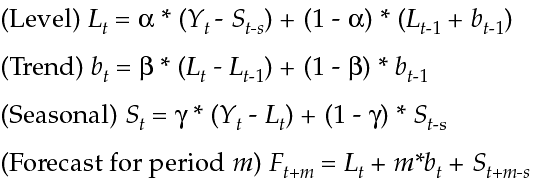

Equações modelo multiplicativo:

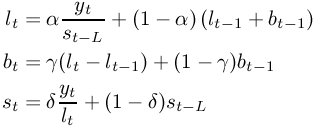

In [ ]:
def update_zeros_vals(arr, seasonality):
  arr_copy = arr.copy()
  index_zeros = np.where(arr_copy <= 0)
  shifted_values = np.array(index_zeros)-seasonality
  shifted_vals = arr_copy[shifted_values]
  arr_copy[index_zeros] = shifted_vals

  return arr_copy

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import numpy as np

history_np = np.array(history)
up_history_np = update_zeros_vals(history_np, 7)

model_hw_add = HWES(up_history_np, seasonal_periods=7, trend='add', seasonal='add')
model_hw_add_fitted = model_hw_add.fit()
model_hw_mult = HWES(up_history_np, seasonal_periods=7, trend='add', seasonal='mul')
model_hw_mult_fitted = model_hw_mult.fit()

In [ ]:
teste = np.append(up_history_np,14)
teste

array([27, 29, 28, ..., 13, 13, 14])

In [ ]:
bics_hw = [model_hw_add_fitted.bic, model_hw_mult_fitted.bic]
bics_hw

In [ ]:
#Walk foward for Holt Winters
def walk_forward_validation_holt_winters(sp, train_data, test_data, mult = None):
  history = [x for x in train_data]
  history_np = np.array(history)
  up_history_np = update_zeros_vals(history_np, sp)
  predictions = list()
  for t in range(len(test_data)):
    if mult is None:
      model = HWES(up_history_np, seasonal_periods=sp, trend='add', seasonal='add')
    else:
      model = HWES(up_history_np, seasonal_periods=sp, trend='add', seasonal='mult')
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    up_history_np = np.append(up_history_np, obs)

  return predictions

predictions_hwa = walk_forward_validation_holt_winters(7, train['Freq'], 
                                                       list(test['Freq']))

predictions_hwm = walk_forward_validation_holt_winters(7, train['Freq'], 
                                                       list(test['Freq']), 1)

O que chama atenção nessa abordagem é como a complexidade interfere no resultado do BIC. O modelo HW é tido como mais simples, pois faz uma análise de comportamento do gráfico e isso é evidenciado por esse critério.

### 6. Análise das métricas

#### 6.1 Predição de modelos

Considerando a validação walk-foward, o tempo para a validação de alguns modelos é considerável. Para facilitar a análise, salvamos os registros em arquivo independente.

In [ ]:
d = {'Pred_AR': list(predictions_ar), 'Pred_MA': list(predictions_ma), 
     'Pred_ARMA': list(predictions_arma), 'Pred_ARIMA': list(predictions_arima), 
     'Pred_SARMA': list(predictions_sarma), 'Pred_SARIMA': list(predictions_sarima), 
     'Pred_HWA': list(predictions_hwa), 'Pred_HWM': list(predictions_hwm), 
     'Actual_Values': list(test['Freq'])}
     
pred_df = pd.DataFrame(data=d)
pred_df.to_csv('pred_values.csv')
pred_df.head()

In [ ]:
pred_df = pd.read_csv('pred_values.csv')
pred_df = pred_df.loc[:, ~pred_df.columns.str.contains('^Unnamed')]
pred_df.head()

,Pred_AR,Pred_MA,Pred_ARMA,Pred_SARMA,Actual_Values,Pred_SARIMA,Pred_SARIMAX,Pred_HWA,Pred_HWM,Pred_SARIMA_2
0,17.752777,18.708141,27.265505,25.552167,10,25.947306,13.300095,28.014370,27.766531,27.472398
1,21.511868,22.085373,23.594395,23.436122,30,23.666807,24.143016,25.711057,26.858706,25.817351
2,27.467605,26.950331,22.802592,24.420095,21,24.711222,25.331927,25.602573,27.032819,28.600646
3,27.056348,25.083148,25.755789,24.534205,18,24.824976,25.375222,24.784156,26.712038,26.554344
4,20.323969,19.415158,13.244943,15.844898,24,16.047818,15.670912,16.937316,26.228658,18.449287


#### 6.2 Modelo AR
Análise do modelo AR

Test RMSE: 8.300
Test MAE: 6.638


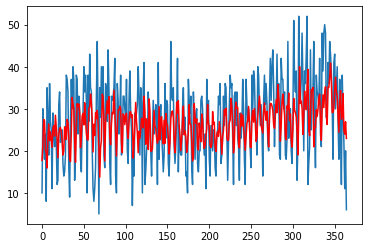

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_ar = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_AR'], squared=False)
mae_ar = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_AR'])
print('Test RMSE: %.3f' % rmse_ar)
print('Test MAE: %.3f' % mae_ar)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_AR'], color='red')
plt.show()

#### 6.3 Modelo MA
Análise do modelo MA

Test RMSE: 8.822
Test MAE: 7.216


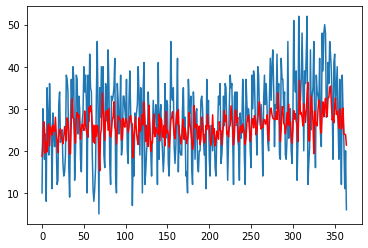

In [ ]:
rmse_ma = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_MA'], squared=False)
mae_ma = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_MA'])
print('Test RMSE: %.3f' % rmse_ma)
print('Test MAE: %.3f' % mae_ma)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_MA'], color='red')
plt.show()

#### 6.4 Modelo ARMA
Análise do modelo ARMA

Test RMSE: 7.380
Test MAE: 5.529


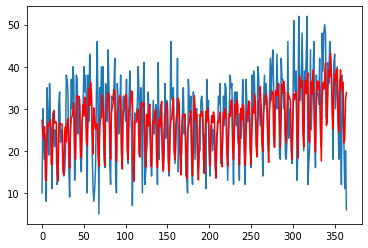

In [ ]:
rmse_arma = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_ARMA'], squared=False)
mae_arma = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_ARMA'])
print('Test RMSE: %.3f' % rmse_arma)
print('Test MAE: %.3f' % mae_arma)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_ARMA'], color='red')
plt.show()

#### 6.5 Modelo SARMA
Análise do modelo SARMA

Test RMSE: 7.121
Test MAE: 5.369


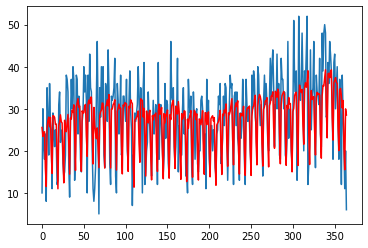

In [ ]:
rmse_sarma = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_SARMA'], squared=False)
mae_sarma = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_SARMA'])
print('Test RMSE: %.3f' % rmse_sarma)
print('Test MAE: %.3f' % mae_sarma)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_SARMA'], color='red')
plt.show()

#### 6.6 Modelo SARIMA
Análise do modelo SARIMA

Test RMSE: 7.127
Test MAE: 5.374


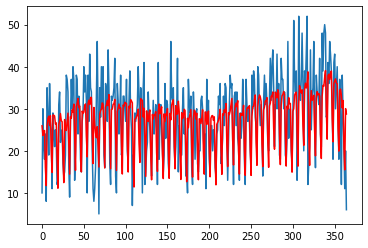

In [ ]:
rmse_sarima = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_SARIMA'], squared=False)
mae_sarima = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_SARIMA'])
print('Test RMSE: %.3f' % rmse_sarima)
print('Test MAE: %.3f' % mae_sarima)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_SARIMA'], color='red')
plt.show()

Test RMSE: 7.184
Test MAE: 5.419


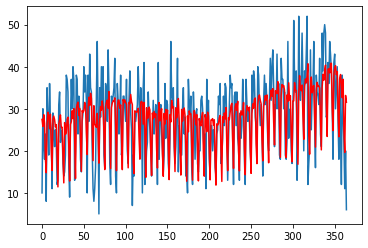

In [ ]:
rmse_sarima_2 = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_SARIMA_2'], squared=False)
mae_sarima_2 = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_SARIMA_2'])
print('Test RMSE: %.3f' % rmse_sarima_2)
print('Test MAE: %.3f' % mae_sarima_2)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_SARIMA_2'], color='red')
plt.show()

#### 6.7 Modelo Holt Winters Aditivo
Análise do modelo Holt Winters Aditivo

Test RMSE: 7.216
Test MAE: 5.454


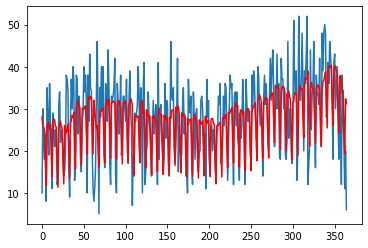

In [ ]:
rmse_hwa = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_HWA'], squared=False)
mae_hwa = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_HWA'])
print('Test RMSE: %.3f' % rmse_hwa)
print('Test MAE: %.3f' % mae_hwa)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_HWA'], color='red')
plt.show()

#### 6.8 Modelo Holt Winters Multiplicativo
Análise do modelo Holt Winters Multiplicativo

Test RMSE: 9.488
Test MAE: 7.894


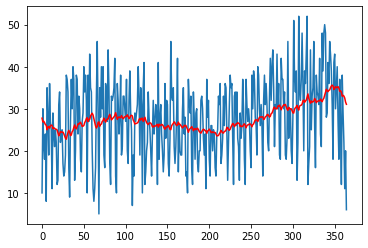

In [ ]:
rmse_hwm = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_HWM'], squared=False)
mae_hwm = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_HWM'])
print('Test RMSE: %.3f' % rmse_hwm)
print('Test MAE: %.3f' % mae_hwm)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_HWM'], color='red')
plt.show()

#### 6.9 Comparativo entre os modelos
Métricas analisadas: RMSE, MAE e BIC

In [ ]:
def get_bic(model_ar, model_ma, model_arma, model_sarma, model_sarima, 
            model_sarima_2, model_hwa, model_hwm, model_name):
  if model_name == 'Pred_AR':
    return model_ar.bic
  elif model_name == 'Pred_MA':
    return model_ma.bic
  elif model_name == 'Pred_ARMA':
    return model_arma.bic
  elif model_name == 'Pred_SARMA':
    return model_sarma.bic
  elif model_name == 'Pred_SARIMA':
    return model_sarima.bic
  elif model_name == 'Pred_SARIMA_2':
    return model_sarima_2.bic
  elif model_name == 'Pred_HWA':
    return model_hwa.bic
  elif model_name == 'Pred_HWM':
    return model_hwm.bic
  else:
    return 0

def calculate_rmse(df, ac_col, model_ar, model_ma, model_arma, model_sarma, 
                   model_sarima, model_sarima_2, model_hwa, model_hwm):
  predictions = list(df.columns[df.columns.str.contains('Pred')])
  rmse = []
  for p in predictions:
    if p != 'Pred_SARIMAX':
      new_val = {}
      new_val['model'] = p
      new_val['rmse'] = mean_squared_error(df[ac_col], pred_df[p], 
                                          squared=False)
      new_val['mae'] = mean_absolute_error(df[ac_col], pred_df[p])
      new_val['bic'] = get_bic(model_ar, model_ma, model_arma, model_sarma, 
                              model_sarima, model_sarima_2, model_hwa, model_hwm, p)
      rmse.append(new_val)
  return pd.DataFrame(rmse)

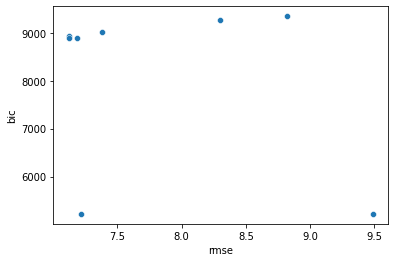

In [ ]:
import seaborn as sns

pred_df = pd.read_csv('pred_values.csv')
results = calculate_rmse(pred_df, 'Actual_Values', model_ar_fitted, model_ma_fitted, 
                         model_arma_fitted, model_sarma_fitted, model_sarima_fitted,
                         model_sarima_2_fitted, model_hw_add_fitted, model_hw_mult_fitted)

sns.scatterplot(data=results, x="rmse", y="bic")

In [ ]:
results

,model,rmse,mae,bic
0,Pred_AR,8.300466,6.638031,9273.283169
1,Pred_MA,8.822384,7.216065,9344.534829
2,Pred_ARMA,7.379600,5.528895,9005.688484
3,Pred_SARMA,7.121159,5.368543,8942.444415
4,Pred_SARIMA,7.126512,5.373725,8887.619850
5,Pred_HWA,7.215803,5.453789,5221.049455
6,Pred_HWM,9.487731,7.893712,5220.933536
7,Pred_SARIMA_2,7.183993,5.419406,8887.619850


De uma forma resumida, é possível tirar algumas conclusões em relação ao modelos implementados:

1. Os modelos de sazonalidade tiveram resultados muito similares. Com isso, é possível perceber que a diferenciação não algo tão relevante para a série.
2. O modelo HW aditivo teve um score muito relevante. A acurácia ficou próxima dos modelos ARIMA com sazonalidade e sua complexidade (medida pela métrica BIC) ficou muito abaixo.

#### 6.10 Análise residual entre dados de treino e teste

Análise do comportamento dos dados de treino e teste da série temporal.

In [ ]:
import seaborn as sns

train_df = df['2015-06-01':'2018-12-31']
test_df = df['2019-01-01':'2019-12-31']
train_decomp = seasonal_decompose(train_df['Freq'], freq=7)
test_decomp = seasonal_decompose(test_df['Freq'], freq=7)
train_data = train_decomp.observed - train_decomp.seasonal
test_data = test_decomp.observed - test_decomp.seasonal

In [ ]:
train_data.describe()

count    1310.000000
mean       24.739573
std         7.593475
min        -3.366572
25%        20.787037
50%        24.840801
75%        29.490246
max        50.490246
Name: Freq, dtype: float64

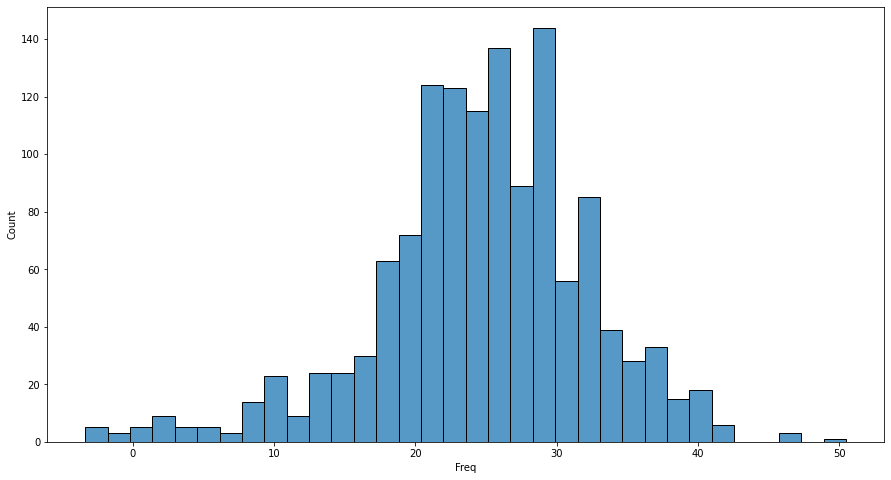

In [ ]:
fig_dims = (15, 8)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)
sns.histplot(x=train_data, ax=ax)

In [ ]:
test_data.describe()

count    365.000000
mean      27.686536
std        7.539206
min        1.995083
25%       23.503324
50%       27.503324
75%       32.196117
max       49.084072
Name: Freq, dtype: float64

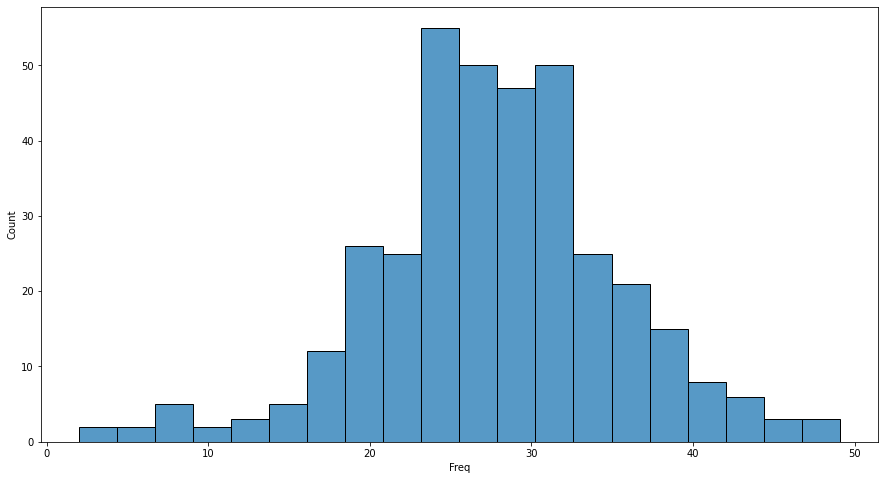

In [ ]:
fig_dims = (15, 8)
fig, ax = plt.subplots(1,1, figsize=fig_dims, sharey=True)
sns.histplot(x=test_data, ax=ax)

Fazendo uma comparação entre a distribuição dos dados de treino e teste, é possível fazer uma análise interessante. Os dados de centralização (média) e dispersão (quartis) estão um pouco deslocados, sendo que o teste possui valores maiores do que o treino. Dessa forma, parte da dificuldade em predizer valores mais extremos é explicada por esse desconhecimento de informação na base de treino.

### 7. Variáveis exógenas

Variáveis que não estão nos dados originais podem ser incluídas como forma de melhorar nossos modelos.

Nesse caso, incluiremos a informação de feriados na cidade de Recife e também se houve chuva no dia do acidente (dados extraídos do Instituto Nacional de Meteorologia)

#### 7.1 Pré processamento variáveis exógenas

In [ ]:
import pandas as pd
import pytz
import datetime
import numpy as np

def create_exog_variables():
  weather_data_2015_file = "INMET_NE_PE_A301_RECIFE_01-01-2015_A_31-12-2015.CSV"
  weather_data_2016_file = "INMET_NE_PE_A301_RECIFE_01-01-2016_A_31-12-2016.CSV"
  weather_data_2017_file = "INMET_NE_PE_A301_RECIFE_01-01-2017_A_31-12-2017.CSV"
  weather_data_2018_file = "INMET_NE_PE_A301_RECIFE_01-01-2018_A_31-12-2018.CSV"
  weather_data_2019_file = "INMET_NE_PE_A301_RECIFE_01-01-2019_A_31-12-2019.CSV"

  all_files = [weather_data_2015_file, weather_data_2016_file, weather_data_2017_file, weather_data_2018_file, weather_data_2019_file]

  li = []

  for filename in all_files:
      file = pd.read_csv(
          filename,
          delimiter=";",
          decimal=",",
          names=['data', 'hora_utc', 'precipitacao_total'],
          header=0,
          parse_dates=[['data', 'hora_utc']],
          dayfirst=True
      )
      li.append(file)

  df = pd.concat(li, axis=0, ignore_index=True)

  df["precipitacao_total"].replace({-9999: 0}, inplace=True)

  df['data_brasil'] = df['data_hora_utc'].dt.tz_localize('GMT').dt.tz_convert('America/Sao_Paulo').dt.date
  del df['data_hora_utc']
  df = df.groupby(['data_brasil'], as_index=False).sum()

  df['precipitacao_binario'] = np.where(df['precipitacao_total'] > 0, 1, 0)

  feriados = [datetime.date(2015, 1, 1),
              datetime.date(2015, 2, 16),
              datetime.date(2015, 2, 17),
              datetime.date(2015, 2, 18),
              datetime.date(2015, 4, 3),
              datetime.date(2015, 4, 21),
              datetime.date(2015, 5, 1),
              datetime.date(2015, 6, 4),
              datetime.date(2015, 6, 24),
              datetime.date(2015, 7, 16),
              datetime.date(2015, 9, 7),
              datetime.date(2015, 10, 12),
              datetime.date(2015, 10, 28),
              datetime.date(2015, 11, 2),
              datetime.date(2015, 11, 15),
              datetime.date(2015, 12, 8),
              datetime.date(2015, 12, 24),
              datetime.date(2015, 12, 25),
              datetime.date(2015, 12, 31),
              datetime.date(2016, 1, 1),
              datetime.date(2016, 2, 8),
              datetime.date(2016, 2, 9),
              datetime.date(2016, 2, 10),
              datetime.date(2016, 3, 25),
              datetime.date(2016, 4, 21),
              datetime.date(2016, 5, 1),
              datetime.date(2016, 5, 26),
              datetime.date(2016, 6, 24),
              datetime.date(2016, 7, 16),
              datetime.date(2016, 9, 7),
              datetime.date(2016, 10, 12),
              datetime.date(2016, 10, 28),
              datetime.date(2016, 11, 2),
              datetime.date(2016, 11, 15),
              datetime.date(2016, 12, 8),
              datetime.date(2016, 12, 24),
              datetime.date(2016, 12, 25),
              datetime.date(2016, 12, 31),
              datetime.date(2017, 1, 1),
              datetime.date(2017, 2, 27),
              datetime.date(2017, 2, 28),
              datetime.date(2017, 3, 1),
              datetime.date(2017, 4, 14),
              datetime.date(2017, 4, 21),
              datetime.date(2017, 5, 1),
              datetime.date(2017, 6, 15),
              datetime.date(2017, 6, 24),
              datetime.date(2017, 7, 16),
              datetime.date(2017, 9, 7),
              datetime.date(2017, 10, 12),
              datetime.date(2017, 10, 28),
              datetime.date(2017, 11, 2),
              datetime.date(2017, 11, 15),
              datetime.date(2017, 12, 8),
              datetime.date(2017, 12, 24),
              datetime.date(2017, 12, 25),
              datetime.date(2017, 12, 31),
              datetime.date(2018, 1, 1),
              datetime.date(2018, 2, 12),
              datetime.date(2018, 2, 13),
              datetime.date(2018, 2, 14),
              datetime.date(2018, 3, 30),
              datetime.date(2018, 4, 21),
              datetime.date(2018, 5, 1),
              datetime.date(2018, 5, 31),
              datetime.date(2018, 6, 24),
              datetime.date(2018, 7, 16),
              datetime.date(2018, 9, 7),
              datetime.date(2018, 10, 12),
              datetime.date(2018, 10, 28),
              datetime.date(2018, 11, 2),
              datetime.date(2018, 11, 15),
              datetime.date(2018, 12, 8),
              datetime.date(2018, 12, 24),
              datetime.date(2018, 12, 25),
              datetime.date(2018, 12, 31),
              datetime.date(2019, 1, 1),
              datetime.date(2019, 3, 4),
              datetime.date(2019, 3, 5),
              datetime.date(2019, 3, 6),
              datetime.date(2019, 4, 19),
              datetime.date(2019, 4, 21),
              datetime.date(2019, 5, 1),
              datetime.date(2019, 6, 20),
              datetime.date(2019, 6, 24),
              datetime.date(2019, 7, 16),
              datetime.date(2019, 9, 7),
              datetime.date(2019, 10, 12),
              datetime.date(2019, 10, 28),
              datetime.date(2019, 11, 2),
              datetime.date(2019, 11, 15),
              datetime.date(2019, 12, 8),
              datetime.date(2019, 12, 24),
              datetime.date(2019, 12, 25),
              datetime.date(2019, 12, 31)]

  df['feriado'] = np.where(df['data_brasil'].isin(feriados), 1, 0)
  df.to_csv('exog_vars.csv')

create_exog_variables()

In [ ]:
df_exog_freq = pd.read_csv('exog_vars.csv')
df_exog_freq = df_exog_freq.loc[:, ~df_exog_freq.columns.str.contains('^Unnamed')]
df_exog_freq['data_brasil'] = pd.to_datetime(df_exog_freq['data_brasil'])
df_exog = df_exog_freq.set_index('data_brasil')
df_exog['month'] = df_exog.index.month
df_exog.head()

,precipitacao_total,precipitacao_binario,feriado,month
data_brasil,,,,
2014-12-31,0.0,0,0,12
2015-01-01,12.0,1,1,1
2015-01-02,6.8,1,0,1
2015-01-03,0.0,0,0,1
2015-01-04,0.0,0,0,1


#### 7.2 Modelo SARIMAX
Análise do modelo SARIMAX

In [ ]:
exog_train_df = df_exog['2015-06-01':'2018-12-31']
exog_test_df = df_exog['2019-01-01':'2019-12-31']

In [ ]:
exog = np.array([exog_train_df['precipitacao_binario'], exog_train_df['feriado'], 
                 exog_train_df['month']]).transpose()
model_sarimax = SARIMAX(history, exog=exog, order=(1, 0, 1),seasonal_order=(1,1,1,7))
model_sarimax_fitted = model_sarimax.fit()
model_sarimax_fitted.bic

8722.545538484861

In [ ]:
exog_test = np.array([exog_test_df['precipitacao_binario'], exog_test_df['feriado'], 
                 exog_test_df['month']]).transpose()
                 
predictions_sarimax = walk_forward_validation_sarimax(1,0,1,1,1,1,7, train['Freq'], 
                                                      list(test['Freq']),exog, 
                                                      exog_test, 3)

In [ ]:
pred_df['Pred_SARIMAX'] = predictions_sarimax
pred_df.to_csv('pred_values.csv')

Test RMSE: 6.325
Test MAE: 4.974


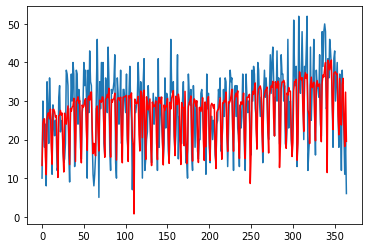

In [ ]:
rmse_sarimax = mean_squared_error(pred_df['Actual_Values'], pred_df['Pred_SARIMAX'], squared=False)
mae_sarimax = mean_absolute_error(pred_df['Actual_Values'], pred_df['Pred_SARIMAX'])
print('Test RMSE: %.3f' % rmse_sarimax)
print('Test MAE: %.3f' % mae_sarimax)
plt.plot(pred_df['Actual_Values'])
plt.plot(pred_df['Pred_SARIMAX'], color='red')
plt.show()

É possível perceber que o modelo com variáveis exógenas melhora consideravalmente a predição dos valores da base de teste. Infelizmente não é possível resolver essa dificuldade de predição de valores extremos, mas talvez isso seja um comportamento atípico da série no ano de 2019.